In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.io import loadmat
from scipy.stats import poisson
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import pandas as pd
# from skimage.metrics import mean_squared_error as mse
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

from ART import ART, worker, get_errors
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])

## EJERCICIO 1

Genero la reconstrucción de la imagen a partir del algoritmo ART y calculo el error cuadrático medio entre la imagen original y la reconstruida.

Iteracion:  1


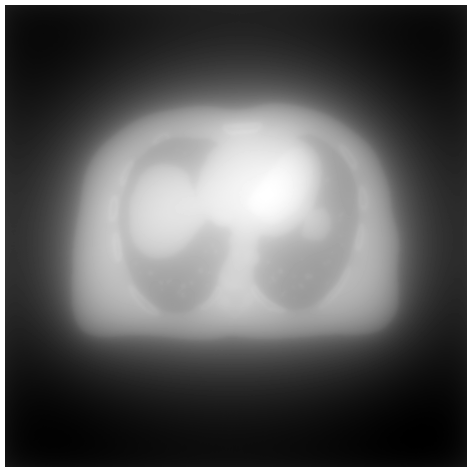

Iteracion:  67


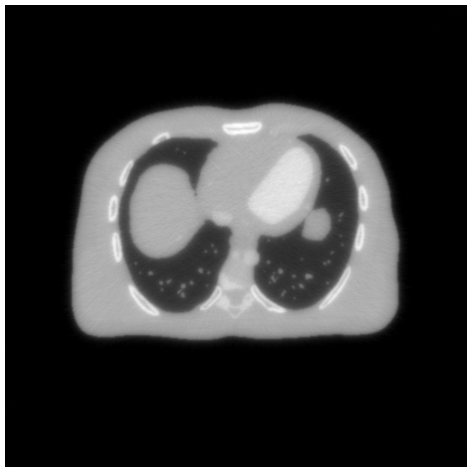

Iteracion:  133


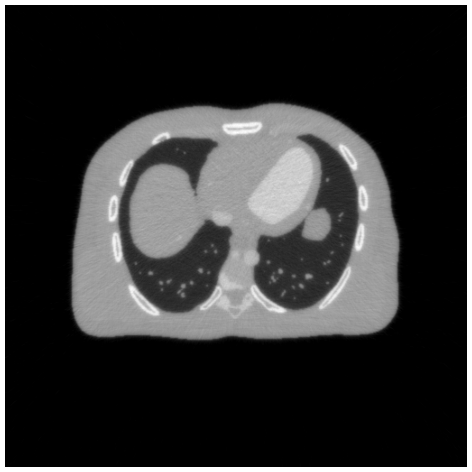

Iteracion:  200


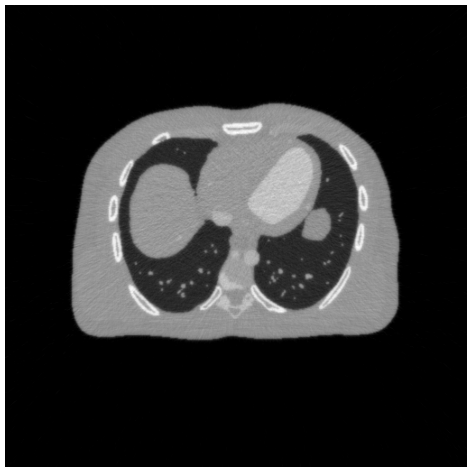

In [2]:
## SYSTEM SETTING
N = 512
ANG = 180
VIEW = 360
THETA = np.linspace(0, ANG, VIEW + 1)
THETA = THETA[:-1]

A = lambda x: radon(x, THETA, circle=False).astype(np.float32)  # Transforma en Radon
AT = lambda y: iradon(y, THETA, circle=False, filter_name=None, output_size=N).astype(np.float32)/(np.pi/(2*len(THETA))) # Transforma en Radon inverso y normaliza por pi/2Ntheta, sin filtro
AINV = lambda y: iradon(y, THETA, circle=False, output_size=N).astype(np.float32)   # Transforma en Radon inverso sin normalizar y con un filtro de rampa


## DATA GENERATION
x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original
p = A(x)    # Sinograma de la imagen original
x_full = AINV(p)    # Imagen reconstruida con el sinograma p

## LOW-DOSE SINOGRAM GENERATION
i0 = 5e4
pn = np.exp(-p)
pn = i0*pn
pn = poisson.rvs(pn)
pn[pn < 1] = 1
pn = -np.log(pn/i0)
pn[pn < 0] = 0  # clipeo los valores negativos

y = pn  # Sinograma de la imagen

# plt.imshow(y, cmap='gray', aspect='auto')

## Algebraic Reconstruction Technique (ART) INITIALIZATION
x_low = AINV(y)
x0 = np.zeros_like(x)
mu = 1e0
niter = 200
bpos = True

x_art = ART(A, AT, y, x0, mu, niter, bpos, True, 4, True, '../doc/images/ej_2/200_iter/reconstruccion_art')

# ## DISPLAY
# wndImg = [0, 0.03]
# wndPrj = [0, 6]

# plt.imshow(x, cmap='gray')
# plt.grid()
# plt.axis('off')
# plt.colorbar()
# plt.savefig('../doc/images/original_ej_2.png', dpi=300, bbox_inches='tight')

# plt.subplot(241)
# plt.imshow(x, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
# plt.axis('off')
# plt.axis('image')
# plt.title('Ground truth')

# plt.subplot(242)
# plt.imshow(x_full, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
# plt.axis('off')
# plt.axis('image')
# plt.title('full-dose')

# plt.subplot(243)
# plt.imshow(x_low, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
# plt.axis('off')
# plt.axis('image')
# plt.title('low-dose\nMSE: %.4f\nPSNR: %.4f\nSSIM: %.4f' % (mse_x_low, psnr_x_low, ssim_x_low))

# plt.subplot(244)
# plt.imshow(x_art, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
# plt.axis('off')
# plt.axis('image')
# plt.title('ART\nMSE: %.4f\nPSNR: %.4f\nSSIM: %.4f' % (mse_x_art, psnr_x_art, ssim_x_art))

# plt.subplot(246)
# plt.imshow(p, cmap='gray', vmin=wndPrj[0], vmax=wndPrj[1])
# plt.title('full-dose\n(VIEW: %d)' % VIEW)
# plt.xlabel('View')
# plt.ylabel('Detector')

# plt.subplot(247)
# plt.imshow(y, cmap='gray', vmin=wndPrj[0], vmax=wndPrj[1])
# plt.title('low-dose\n(VIEW: %d)' % VIEW)
# plt.xlabel('View')
# plt.ylabel('Detector')

# plt.subplot(248)
# plt.imshow(y - p, cmap='gray')
# plt.title('full-dose - low-dose\n(Poisson noise)')
# plt.xlabel('View')
# plt.ylabel('Detector')

plt.show()


In [4]:
## CALCULATE QUANTIFICATION FACTOR
x_low[x_low < 0] = 0
x_art[x_art < 0] = 0
nor = np.amax(x)

mse_x_low = mse(x/nor, x_low/nor)
mse_x_art = mse(x/nor, x_art/nor)

# data_range = max((x/nor).max(), (x_low/nor).max(), (x_art/nor).max()) - min((x/nor).min(), (x_low/nor).min(), (x_art/nor).min())
data_range = 256
print(data_range)

psnr_x_low = psnr(x/nor, x_low/nor)
psnr_x_art = psnr(x/nor, x_art/nor)

ssim_x_low = ssim(x_low/nor, x/nor, data_range=data_range)
ssim_x_art = ssim(x_art/nor, x/nor, data_range=data_range)

print(f'MSE:  low-dose: {mse_x_low:.6f}, ART: {mse_x_art:.6f}')
print(f'PSNR: low-dose: {psnr_x_low:.4f}, ART: {psnr_x_art:.4f}')
print(f'SSIM: low-dose: {ssim_x_low}, ART: {ssim_x_art}')

256
MSE:  low-dose: 0.001521, ART: 0.001188
PSNR: low-dose: 28.1793, ART: 29.2524
SSIM: low-dose: 0.9999560987710614, ART: 0.9999730035537638
